In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from collections import Counter

import sys
sys.path.append('../src')
from utils import w_label_prop
from quality_functions import eval_functions
from parse_data import parse_6dfb

N_NODES = 15801
def read_graph(path="../datasets/fb_dg_gabr"):
    graph = nx.Graph()
    for i in range(N_NODES):
        graph.add_node(i)
    for v, line in enumerate(open(path)):
        edges = map(int, line.split())
        for u in edges:
            graph.add_edge(v, u)
    return graph


def get_comm_sizes_samples(graph, n_samples=10, verbose=True):
    ans = []
    for i in tqdm(range(n_samples)):
        labels, _ = w_label_prop(graph)
        comm_sizes = list(Counter(labels).values())
        ans.append(comm_sizes)
        if i < 5 and verbose:
            print(len(comm_sizes))
            top_sizes = sorted(comm_sizes)[::-1][:5]
            print(top_sizes)
    return ans


graph_conn = parse_6dfb()
labels_conn, _ = w_label_prop(graph_conn)

100%|██████████| 10/10 [00:44<00:00,  4.33s/it]


In [3]:
%%time

labels_conn, _ = w_label_prop(graph_conn)

CPU times: user 1.76 s, sys: 155 ms, total: 1.91 s
Wall time: 14.2 s


EPS
N_nodes: 15801
N_edges: 117864
Ratio: 7.459274729447503
Time 9.494620084762573
N_comm: 3488
UNSHUFFLED
global_density : 0.733598269519483
local_density : 0.8015434255741214
distance_based : 0.9988760756174268
node_membership : 0.8015434255741212
SHUFFLED
global_density : 0.5177114871873115
local_density : 0.6102810069968141
distance_based : 0.9973374464803468
node_membership : 0.6102810069968148

GABR
N_nodes: 15801
N_edges: 109121
Ratio: 6.905955319283589
Time 11.304552555084229
N_comm: 355
UNSHUFFLED
global_density : 0.5562447258146357
local_density : 0.5961986511799069
distance_based : 0.9943432653359723
node_membership : 0.5961986511799061
SHUFFLED
global_density : 0.5051542560256583
local_density : 0.5111929893145264
distance_based : 0.9931056235747052
node_membership : 0.5111929893145258

INF
N_nodes: 15801
N_edges: 15410
Ratio: 0.975254730713246
Time 3.0764124393463135
N_comm: 6053
UNSHUFFLED
global_density : 0.69453249769461
local_density : 0.7576953639930364
distance_based

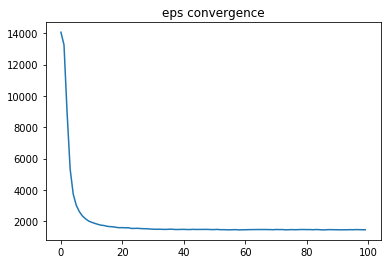

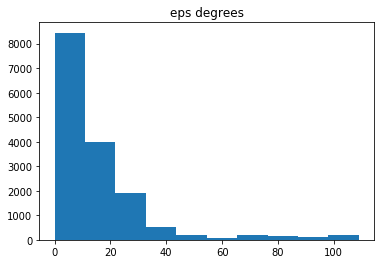

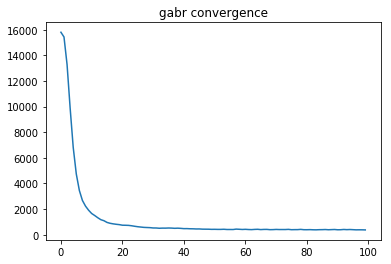

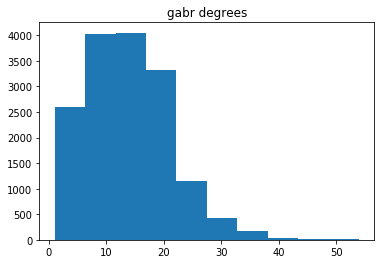

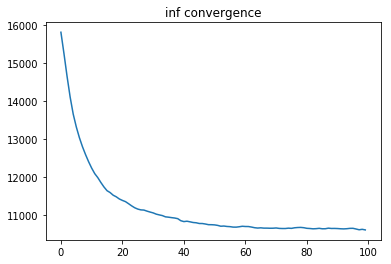

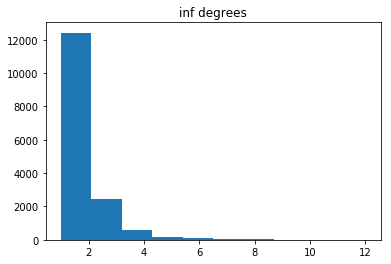

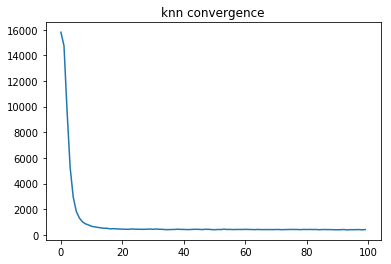

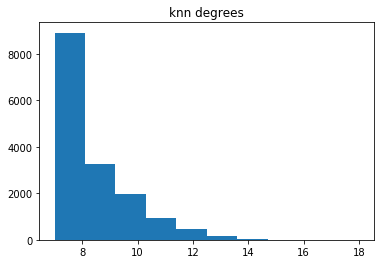

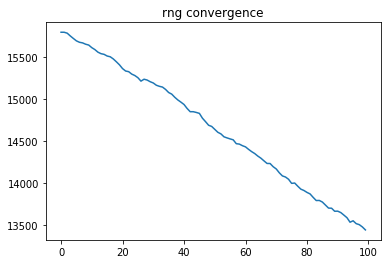

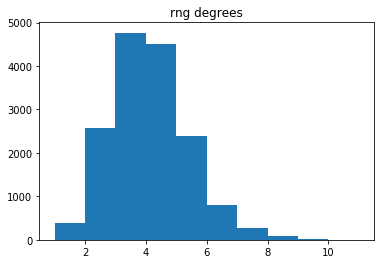

<Figure size 432x288 with 0 Axes>

In [2]:
%%time

from time import time

graph_types = ['eps', 'gabr', 'inf', 'knn', 'rng']
dg_labels = dict()

for fname in graph_types:
    print(fname.upper())
    graph = read_graph('../datasets/fb_dg_' + fname)
    print("N_nodes:", graph.number_of_nodes())
    print("N_edges:", graph.number_of_edges())
    print("Ratio:", graph.number_of_edges() / graph.number_of_nodes())
    t_begin = time()
    labels, deltas = w_label_prop(graph)
    print("Time", time() - t_begin)
    dg_labels[fname] = labels
    plt.title(fname + " convergence")
    plt.plot(deltas)
    plt.figure()
    plt.title(fname + " degrees")
    plt.hist([graph.degree(i) for i in graph.nodes()])
    plt.figure()
    print("N_comm:", len(set(labels)))
    eval_functions(labels, graph)
    print()

In [3]:
def cnt_equal(array):
    cnt = dict()
    for i in array:
        if i in cnt:
            cnt[i] += 1
        else:
            cnt[i] = 1
    ans = 0
    for i in cnt.values():
        ans += (i * (i - 1)) // 2
    return ans
        

def get_n_pairs(labels_1, labels_2):
    return cnt_equal(labels_1), cnt_equal(labels_2), cnt_equal(list(zip(labels_1, labels_2)))

for fname in graph_types:
    cnt_conn, cnt_dg, cnt_common = get_n_pairs(labels_conn, dg_labels[fname])
    print(fname)
    print(cnt_conn, cnt_dg, cnt_common)
    n_pairs = N_NODES * (N_NODES - 1) // 2
    print((cnt_common * n_pairs) / (cnt_conn * cnt_dg))

eps
70128469 243605 145048
1.059846215905126
gabr
70128469 808099 599829
1.321235384205781
inf
70128469 30040 20585
1.2197427618169343
knn
70128469 105538 77622
1.3091616516053295
rng
70128469 379910 299878
1.4050157320784578


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


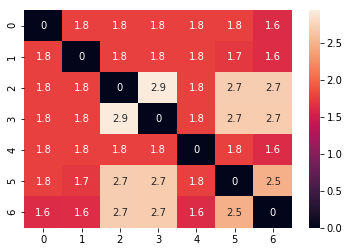

In [4]:
import seaborn as sns
import numpy as np

labels_conn_list = [labels_conn]
n_samples = 7
for i in range(n_samples - 1):
    labels_conn_list.append(w_label_prop(graph_conn)[0])
matrix = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(i + 1, n_samples):
        cnt_1, cnt_2, cnt_common = get_n_pairs(labels_conn_list[i], labels_conn_list[j])
        n_pairs = N_NODES * (N_NODES - 1) // 2
        matrix[i][j] = (cnt_common * n_pairs) / (cnt_1 * cnt_2)
        matrix[j][i] = matrix[i][j]
sns.heatmap(matrix, annot=True)

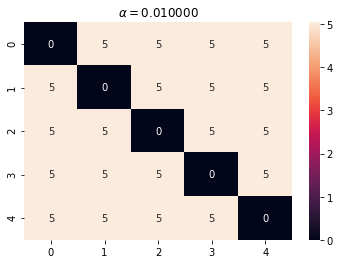

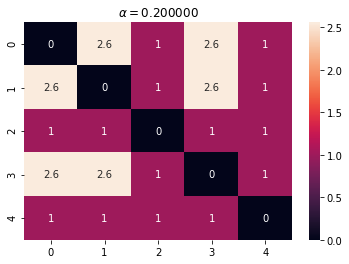

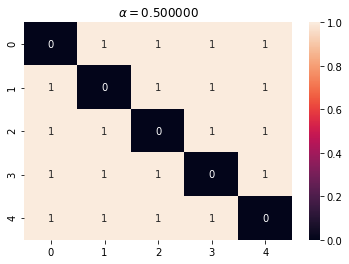

<Figure size 432x288 with 0 Axes>

In [5]:
from utils import gen_sbm_graph

for alpha in [0.01, 0.2, 0.5]:
    sbm_graph = gen_sbm_graph([100 for i in range(5)], 1 - alpha, alpha)
    labels_sbm_list = []
    n_samples = 5
    for i in range(n_samples):
        labels_sbm_list.append(w_label_prop(sbm_graph)[0])
    matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            cnt_1, cnt_2, cnt_common = get_n_pairs(labels_sbm_list[i], labels_sbm_list[j])
            n_pairs = sbm_graph.number_of_nodes() * (sbm_graph.number_of_nodes() - 1) // 2
            matrix[i][j] = (cnt_common * n_pairs) / (cnt_1 * cnt_2)
            matrix[j][i] = matrix[i][j]
    plt.title("$\\alpha=%f$" % alpha)
    sns.heatmap(matrix, annot=True)
    plt.figure()

In [6]:
from pickle import dump
with open("../tmp_files/6dfb_cd.pickle", "wb") as f:
    names = ['connections'] + graph_types
    graphs = [graph_conn]
    print("CONNECTIONS")
    samples = [get_comm_sizes_samples(graph_conn)]
    for g_type in graph_types:
        print(g_type.upper())
        dg_graph = read_graph('../datasets/fb_dg_' + g_type)
        graphs.append(dg_graph)
        samples.append(get_comm_sizes_samples(dg_graph))
    #dump(names, f)
    dump(graphs, f)
    dump(samples, f)

  0%|          | 0/10 [00:00<?, ?it/s]

CONNECTIONS


 10%|█         | 1/10 [00:14<02:13, 14.78s/it]

2829
[11802, 1137, 10, 6, 5]


 20%|██        | 2/10 [00:30<02:01, 15.20s/it]

2830
[8484, 3256, 1201, 10, 5]


 30%|███       | 3/10 [00:47<01:48, 15.49s/it]

2829
[8453, 3338, 1152, 10, 6]


 40%|████      | 4/10 [01:02<01:32, 15.40s/it]

2827
[11793, 1154, 10, 6, 4]


 50%|█████     | 5/10 [01:18<01:18, 15.61s/it]

2830
[4725, 3843, 3221, 1155, 10]


100%|██████████| 10/10 [02:34<00:00, 15.19s/it]


EPS


 10%|█         | 1/10 [00:11<01:40, 11.12s/it]

3502
[150, 149, 141, 128, 120]


 20%|██        | 2/10 [00:22<01:28, 11.09s/it]

3492
[150, 142, 122, 116, 111]


 30%|███       | 3/10 [00:33<01:18, 11.18s/it]

3493
[149, 143, 121, 117, 116]


 40%|████      | 4/10 [00:45<01:08, 11.36s/it]

3492
[152, 128, 110, 97, 97]


 50%|█████     | 5/10 [00:56<00:56, 11.37s/it]

3475
[147, 111, 110, 108, 102]


100%|██████████| 10/10 [01:53<00:00, 11.41s/it]


GABR


 10%|█         | 1/10 [00:13<01:58, 13.12s/it]

344
[319, 313, 283, 265, 260]


 20%|██        | 2/10 [00:26<01:44, 13.12s/it]

336
[445, 278, 261, 246, 240]


 30%|███       | 3/10 [00:39<01:32, 13.19s/it]

352
[290, 276, 252, 249, 240]


 40%|████      | 4/10 [00:52<01:19, 13.21s/it]

347
[562, 323, 305, 291, 218]


 50%|█████     | 5/10 [01:06<01:06, 13.28s/it]

356
[293, 272, 223, 221, 214]


100%|██████████| 10/10 [02:11<00:00, 13.08s/it]


INF


 10%|█         | 1/10 [00:03<00:29,  3.26s/it]

6073
[22, 21, 20, 20, 20]


 20%|██        | 2/10 [00:06<00:26,  3.25s/it]

6054
[22, 21, 21, 20, 19]


 30%|███       | 3/10 [00:09<00:22,  3.24s/it]

6044
[21, 21, 21, 19, 19]


 40%|████      | 4/10 [00:13<00:19,  3.27s/it]

6051
[23, 21, 21, 20, 20]


 50%|█████     | 5/10 [00:16<00:16,  3.27s/it]

6052
[28, 26, 21, 21, 21]


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


KNN


 10%|█         | 1/10 [00:08<01:13,  8.21s/it]

1323
[38, 34, 32, 31, 30]


 20%|██        | 2/10 [00:16<01:06,  8.25s/it]

1325
[37, 36, 34, 33, 32]


 30%|███       | 3/10 [00:24<00:57,  8.22s/it]

1322
[36, 34, 34, 31, 31]


 40%|████      | 4/10 [00:32<00:49,  8.18s/it]

1317
[52, 37, 36, 35, 33]


 50%|█████     | 5/10 [00:40<00:40,  8.16s/it]

1302
[44, 38, 37, 37, 35]


100%|██████████| 10/10 [01:21<00:00,  8.11s/it]


RNG


 10%|█         | 1/10 [00:07<01:04,  7.22s/it]

1432
[296, 138, 121, 111, 107]


 20%|██        | 2/10 [00:13<00:54,  6.79s/it]

1363
[250, 233, 231, 175, 164]


 30%|███       | 3/10 [00:18<00:45,  6.49s/it]

1390
[155, 121, 120, 119, 115]


 40%|████      | 4/10 [00:24<00:37,  6.30s/it]

1389
[478, 310, 186, 183, 160]


 50%|█████     | 5/10 [00:30<00:30,  6.14s/it]

1322
[419, 174, 157, 134, 127]


100%|██████████| 10/10 [00:59<00:00,  5.86s/it]


In [8]:
from networkx.algorithms.components import connected_components

def comp_sizes(graph, max_c_size=20):
    comps = []
    for c in connected_components(graph):
        comps.append(len(c))
    return comps

with open("../tmp_files/6dfb_csizes.pickle", "wb") as f:
    for g_type in ['conn'] + graph_types:
        print(g_type.upper())
        if g_type != 'conn':
            graph = read_graph('../datasets/fb_dg_' + g_type)
        else:
            graph = graph_conn
        sizes = comp_sizes(graph)
        print(sorted(sizes)[::-1][:10])
        dump(sizes, f)

CONN
[12970, 11, 3, 3, 3, 3, 3, 2, 2, 2]
EPS
[1811, 1630, 1497, 1259, 1066, 1003, 558, 471, 451, 451]
GABR
[15801]
INF
[66, 55, 51, 43, 40, 39, 39, 38, 38, 37]
KNN
[4505, 2337, 2257, 1880, 1821, 981, 525, 339, 339, 172]
RNG
[15801]
